# 1. Comparing Sentinel-1 RTC datasets

Now that we have constructed and organized data cubes for both the ASF and Planetary Computer datasets, it would be useful and informative to compare the two. This notebook will demonstrate steps to ensure a direct comparison between the two datasets as well as use of xarray plotting tools for a preliminary visual comparison.

## Learning goals

**Xarray and python techniques:**
- Conditional selection based on non-dimensional coordinates using `xr.Dataset.where()`
- Subsetting datasets based on dimensional coordinates using `xr.DataArray.isin()`
- Adding dimensional and non-dimensional coordinates to `xr.Dataset` objects
- Xarray plotting methods
- Projecting xarray objects to different grids using `xr.interp_like()`

**High-level science goals**
- Comparing and evaluating multiple datasets
- Setting up multiple datasets for direct comparisons
- Handling differences in spatial resolution 

### Other useful resources
These are resources that contain additional examples and discussion of the content in this notebook and more.
- [Xarray user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)
- [How do I...](https://docs.xarray.dev/en/stable/howdoi.html) this is **very** helpful!
- [Xarray High-level computational patterns](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html) discussion of concepts and associated code examples
- [Parallel computing with dask](https://tutorial.xarray.dev/intermediate/xarray_and_dask.html) Xarray tutorial demonstrating wrapping of dask arrays

In [1]:
%xmode minimal
import xarray as xr
import os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask

%matplotlib inline

Exception reporting mode: Minimal


## Overview

While the datasets we will be comparing in this notebook are quite similar, they contain important differences related to how they were processed. The product description pages for both datasets contain important information for understanding how they are generated.

### Source data
One important difference is the source data used to generate the RTC images. ASF uses the Single Look Complex ([SLC](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/single-look-complex)) images that contains both amplitude and phase information for each pixel, is in radar coordinates and has not yet been multi-looked. The Microsoft Planetary Computer RTC imagery is generate from ground range detected images (GRD). [GRD](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/ground-range-detected) data has been detected, multi-looked and projected to ground range.

### DEM
A digital elevation model (DEM) is an important input parameter for RTC processing. ASF RTC processing uses the Copernicus DEM with 30 m resolution. Planetary Computer uses higher resolution DEMs. One effect of the use of different DEMs during RTC processing is the different spatial resolutions of the RTC products: **Planetary Computer RTC imagery has a spatial resolution of 10 meters while ASF RTC imagery has a spatial resolution of 30 meters.**

## Software and setup

In [1]:
import xarray as xr

import s1_tools

from s1_tools import points2coords

import os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask
import holoviews as hv
from holoviews import opts

### Utility functions

In [2]:
def power_to_db(input_arr):
    return 10 * np.log10(np.abs(input_arr))

In [3]:
def asf_pc_sidebyside(asf_input, pc_input, timestep):
    fig, axs = plt.subplots(ncols=2, figsize=(15, 10))

    power_to_db(asf_input.vv.isel(acq_date=timestep)).plot(
        ax=axs[0], cmap=plt.cm.Greys_r, label="ASF"
    )
    power_to_db(pc_input.vv.isel(time=timestep)).plot(
        ax=axs[1], cmap=plt.cm.Greys_r, label="PC"
    )

In [4]:
def single_time_mean_compare(asf_input, pc_input, time):
    fig, ax = plt.subplots(figsize=(8, 8))
    power_to_db(asf_input["vv"].isel(acq_date=time).mean(dim=["x", "y"])).plot(ax=ax)
    power_to_db(pc_input["vv"].isel(time=time).mean(dim=["x", "y"])).plot(
        ax=ax, color="red"
    )

### Read in prepared data

We can use the `storemagic` command `%store` to retrieve the variable we constructed and saved in a previous notebook, rather than having to create it again. Read more about this [here](https://levelup.gitconnected.com/how-to-store-variables-in-jupyter-notebook-fea8aa60a9b)

This let's us call the ASF dataset (`vrt_new`) and PC dataset (`da_pc`)

In [6]:
pc_cube = xr.open_dataset("../data/tutorial2/s1_pc_cube.zarr", engine="zarr")

In [7]:
asf_cube = xr.open_dataset("../data/tutorial2/s1_asf_cube_updated.zarr", engine="zarr")

Read in the ASF dataset, which we named `vrt_full` in the earlier notebook:

In [8]:
asf_cube

<xarray.Dataset> Size: 265MB
Dimensions:                           (acq_date: 96, y: 396, x: 290)
Coordinates: (12/22)
  * acq_date                          (acq_date) datetime64[ns] 768B 2021-05-...
    area_or_clipped                   (acq_date) <U1 384B ...
    beam_mode                         (acq_date) <U2 768B ...
    data_take_id                      (acq_date) <U6 2kB ...
    deadreckoning_or_demmatch         (acq_date) <U1 384B ...
    granule_id                        (acq_date) <U67 26kB ...
    ...                                ...
    sensor                            (acq_date) <U3 1kB ...
    spatial_ref                       int64 8B ...
    terrain_correction_pixel_spacing  (acq_date) <U5 2kB ...
    unmasked_or_watermasked           (acq_date) <U1 384B ...
  * x                                 (x) float64 2kB 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3kB 3.102e+06 ... 3.09e+06
Data variables:
    ls                                (acq_date, y, x) float64 88MB ...
    vh                                (acq_date, y, x) float64 88MB ...
    vv                                (acq_date, y, x) float64 88MB ...

Before we go further, the nodata value for the ASF dataset is currently zero. Change all zero values to NaN:

In [9]:
asf_cube = asf_cube.where(asf_cube.vv != 0.0, np.nan, drop=False)

In [10]:
asf_cube

<xarray.Dataset> Size: 265MB
Dimensions:                           (acq_date: 96, y: 396, x: 290)
Coordinates: (12/22)
  * acq_date                          (acq_date) datetime64[ns] 768B 2021-05-...
    area_or_clipped                   (acq_date) <U1 384B 'e' 'e' ... 'e' 'e'
    beam_mode                         (acq_date) <U2 768B 'IW' 'IW' ... 'IW'
    data_take_id                      (acq_date) <U6 2kB '047321' ... '052C00'
    deadreckoning_or_demmatch         (acq_date) <U1 384B 'd' 'd' ... 'd' 'd'
    granule_id                        (acq_date) <U67 26kB 'S1A_IW_SLC__1SDV_...
    ...                                ...
    sensor                            (acq_date) <U3 1kB 'S1A' 'S1A' ... 'S1A'
    spatial_ref                       int64 8B 0
    terrain_correction_pixel_spacing  (acq_date) <U5 2kB 'RTC30' ... 'RTC30'
    unmasked_or_watermasked           (acq_date) <U1 384B 'u' 'u' ... 'u' 'u'
  * x                                 (x) float64 2kB 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3kB 3.102e+06 ... 3.09e+06
Data variables:
    ls                                (acq_date, y, x) float64 88MB nan ... 1.0
    vh                                (acq_date, y, x) float64 88MB nan ... 0...
    vv                                (acq_date, y, x) float64 88MB nan ... 0...

## Extract common data take ID from granule IDs

We want to ensure that we are performing a direct comparison of the ASF and PC datasets. To do this, we would like to use the acquisition ID that is stored in the source granule name (published by ESA). In the setup notebooks we attached the entire granule IDs of the SLC images to the ASF dataset and the GRD images to the PC dataset. In the ASF data inspection notebook, we attached data take id as a non-dimensional coordinate. Now we will do the same for the Planetary Computer dataset, extracting just the 6-digit acquisition ID from the granule ID and using this for a scene-by-scene comparison.

In [11]:
data_take_pc = [
    str(pc_cube.isel(time=t).granule_id.values)[56:] for t in range(len(pc_cube.time))
]

Assign `data_take_id` as a non-dimensional coordinate. Rather than use the `xr.assign_coords()` function, we are adding the object by specifying a tuple with the form ('coord_name', coord_data, attrs):

In [12]:
pc_cube.coords["data_take_id"] = ("time", data_take_pc)

In [13]:
asf_cube

<xarray.Dataset> Size: 265MB
Dimensions:                           (acq_date: 96, y: 396, x: 290)
Coordinates: (12/22)
  * acq_date                          (acq_date) datetime64[ns] 768B 2021-05-...
    area_or_clipped                   (acq_date) <U1 384B 'e' 'e' ... 'e' 'e'
    beam_mode                         (acq_date) <U2 768B 'IW' 'IW' ... 'IW'
    data_take_id                      (acq_date) <U6 2kB '047321' ... '052C00'
    deadreckoning_or_demmatch         (acq_date) <U1 384B 'd' 'd' ... 'd' 'd'
    granule_id                        (acq_date) <U67 26kB 'S1A_IW_SLC__1SDV_...
    ...                                ...
    sensor                            (acq_date) <U3 1kB 'S1A' 'S1A' ... 'S1A'
    spatial_ref                       int64 8B 0
    terrain_correction_pixel_spacing  (acq_date) <U5 2kB 'RTC30' ... 'RTC30'
    unmasked_or_watermasked           (acq_date) <U1 384B 'u' 'u' ... 'u' 'u'
  * x                                 (x) float64 2kB 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3kB 3.102e+06 ... 3.09e+06
Data variables:
    ls                                (acq_date, y, x) float64 88MB nan ... 1.0
    vh                                (acq_date, y, x) float64 88MB nan ... 0...
    vv                                (acq_date, y, x) float64 88MB nan ... 0...

In [14]:
pc_cube

<xarray.Dataset> Size: 3GB
Dimensions:                                (time: 143, y: 1542, x: 888)
Coordinates: (12/36)
    constellation                          <U10 40B ...
    end_datetime                           (time) <U32 18kB ...
    epsg                                   int64 8B ...
    granule_id                             (time) <U62 35kB ...
    id                                     (time) <U66 38kB ...
    platform                               <U11 44B ...
    ...                                     ...
    sat:relative_orbit                     (time) int64 1kB ...
    start_datetime                         (time) <U32 18kB ...
  * time                                   (time) datetime64[ns] 1kB 2021-01-...
  * x                                      (x) float64 7kB 6.194e+05 ... 6.28...
  * y                                      (y) float64 12kB 3.102e+06 ... 3.0...
    data_take_id                           (time) <U6 3kB '043653' ... '054B39'
Data variables:
    vh                                     (time, y, x) float64 2GB ...
    vv                                     (time, y, x) float64 2GB ...
Attributes:
    crs:            epsg:32645
    resolution_xy:  [9.788706070864338, 7.699930607059487]
    spec_dict:      {'bounds': [619419.5314582244, 3089781.9544171887, 628111...
    transform:      [9.788706070864338, 0.0, 619419.5314582244, 0.0, -7.69993...

### Subset to only common data takes

Now we have data take ID coordinates for both datasets. We want to find the common data take IDs between the two datasets. To do this, I extract a list of the acquisition IDs (`data_take_id`) for both datasets and then find the intersection of the two lists (the list object `common_data_takes`)

In [15]:
pc_data_take_ls = list(pc_cube.data_take_id.values)
asf_data_take_ls = list(asf_cube.data_take_id.values)

In [16]:
common_data_takes = list(set(pc_data_take_ls) & set(asf_data_take_ls))
len(common_data_takes)

96

It looks like there are 83 RTC images that are generated from common acquisitions between the two datasets

We'd like to subset the ASF and the PC datasets to only the common acquisitions. The xarray `.isin()` method is very useful for this type of selection. 

In [17]:
subset_condition_asf = asf_cube.data_take_id.isin(common_data_takes)

subset_condition_pc = pc_cube.data_take_id.isin(common_data_takes)

Next, we want to select the elements along the `acq_ate` (and `time`) dimensions where `data_take_id` satisfies the requirement of being in the `common_data_takes` list. I found this stack overflow answer useful for this step: [https://stackoverflow.com/questions/70777676/xarray-select-dataarray-according-to-an-non-dimension-coordinate](https://stackoverflow.com/questions/70777676/xarray-select-dataarray-according-to-an-non-dimension-coordinate).

In [43]:
asf_subset = asf_cube.sel(acq_date=asf_cube.data_take_id.isin(common_data_takes))

In [44]:
asf_subset.acq_date

<xarray.DataArray 'acq_date' (acq_date: 96)> Size: 768B
array(['2021-05-02T12:14:14.000000000', '2021-05-05T00:03:07.000000000',
       '2021-05-09T12:05:42.000000000', '2021-05-14T12:13:49.000000000',
       '2021-05-17T00:03:08.000000000', '2021-05-21T12:05:43.000000000',
       '2021-05-26T12:13:50.000000000', '2021-05-29T00:03:09.000000000',
       '2021-06-02T12:05:43.000000000', '2021-06-07T12:13:51.000000000',
       '2021-06-10T00:03:10.000000000', '2021-06-14T12:05:44.000000000',
       '2021-06-19T12:13:52.000000000', '2021-06-22T00:03:10.000000000',
       '2021-06-26T12:05:45.000000000', '2021-07-01T12:13:52.000000000',
       '2021-07-04T00:03:11.000000000', '2021-07-08T12:05:45.000000000',
       '2021-07-13T12:13:53.000000000', '2021-07-16T00:03:12.000000000',
       '2021-07-20T12:05:46.000000000', '2021-07-25T12:13:54.000000000',
       '2021-07-28T00:03:12.000000000', '2021-08-01T12:05:47.000000000',
       '2021-08-06T12:13:54.000000000', '2021-08-09T00:03:13.000000000',
       '2021-08-13T12:05:48.000000000', '2021-08-18T12:13:55.000000000',
       '2021-08-21T00:03:14.000000000', '2021-08-25T12:05:48.000000000',
       '2021-08-30T12:13:56.000000000', '2021-09-02T00:03:14.000000000',
       '2021-09-06T12:05:49.000000000', '2021-09-11T12:13:56.000000000',
       '2021-09-14T00:03:15.000000000', '2021-09-18T12:05:49.000000000',
       '2021-09-23T12:13:57.000000000', '2021-09-26T00:03:15.000000000',
       '2021-09-30T12:05:50.000000000', '2021-10-05T12:13:57.000000000',
       '2021-10-08T00:03:15.000000000', '2021-10-12T12:05:50.000000000',
       '2021-10-17T12:13:57.000000000', '2021-10-20T00:03:16.000000000',
       '2021-10-24T12:05:50.000000000', '2021-10-29T12:13:57.000000000',
       '2021-11-01T00:03:15.000000000', '2021-11-05T12:05:49.000000000',
       '2021-11-10T12:13:57.000000000', '2021-11-13T00:03:15.000000000',
       '2021-11-17T12:05:49.000000000', '2021-11-22T12:13:56.000000000',
       '2021-11-25T00:03:15.000000000', '2021-11-29T12:05:49.000000000',
       '2021-12-04T12:13:56.000000000', '2021-12-07T00:03:14.000000000',
       '2021-12-11T12:05:48.000000000', '2021-12-16T12:13:55.000000000',
       '2021-12-19T00:03:14.000000000', '2021-12-23T12:05:48.000000000',
       '2021-12-28T12:13:55.000000000', '2021-12-31T00:03:13.000000000',
       '2022-01-04T12:05:47.000000000', '2022-01-09T12:13:54.000000000',
       '2022-01-12T00:03:13.000000000', '2022-01-16T12:05:47.000000000',
       '2022-01-21T12:13:54.000000000', '2022-01-24T00:03:12.000000000',
       '2022-01-28T12:05:46.000000000', '2022-02-02T12:13:53.000000000',
       '2022-02-05T00:03:12.000000000', '2022-02-09T12:05:46.000000000',
       '2022-02-14T12:13:53.000000000', '2022-02-17T00:03:11.000000000',
       '2022-02-21T12:05:46.000000000', '2022-02-26T12:13:53.000000000',
       '2022-03-01T00:03:11.000000000', '2022-03-05T12:05:45.000000000',
       '2022-03-10T12:13:53.000000000', '2022-03-13T00:03:11.000000000',
       '2022-03-17T12:05:45.000000000', '2022-03-22T12:13:53.000000000',
       '2022-03-25T00:03:12.000000000', '2022-03-29T12:05:46.000000000',
       '2022-04-03T12:13:53.000000000', '2022-04-06T00:03:12.000000000',
       '2022-04-10T12:05:46.000000000', '2022-04-15T12:13:53.000000000',
       '2022-04-18T00:03:12.000000000', '2022-04-22T12:05:47.000000000',
       '2022-04-27T12:13:54.000000000', '2022-04-30T00:03:13.000000000',
       '2022-05-04T12:05:47.000000000', '2022-05-09T12:13:55.000000000',
       '2022-05-16T12:05:48.000000000', '2022-05-21T12:13:56.000000000'],
      dtype='datetime64[ns]')
Coordinates: (12/20)
  * acq_date                          (acq_date) datetime64[ns] 768B 2021-05-...
    area_or_clipped                   (acq_date) <U1 384B 'e' 'e' ... 'e' 'e'
    beam_mode                         (acq_date) <U2 768B 'IW' 'IW' ... 'IW'
    data_take_id                      (acq_date) <U6 2kB '047321' ... '052C00'
    deadreckoning_or_demmatch         (acq_date) <U1 384B 'd' 'd' ... 'd'

In [45]:
pc_subset = pc_cube.sel(time=pc_cube.data_take_id.isin(common_data_takes))

In [46]:
pc_subset["vv"].encoding

{'chunks': (18, 193, 111),
 'preferred_chunks': {'time': 18, 'y': 193, 'x': 111},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float64'),
 'coordinates': 'constellation end_datetime epsg granule_id id platform proj:code s1:datatake_id s1:instrument_configuration_ID s1:orbit_source s1:processing_level s1:product_timeliness s1:resolution s1:slice_number s1:total_slices sar:center_frequency sar:frequency_band sar:instrument_mode sar:looks_azimuth sar:looks_equivalent_number sar:looks_range sar:observation_direction sar:pixel_spacing_azimuth sar:pixel_spacing_range sar:product_type sar:resolution_azimuth sar:resolution_range sat:absolute_orbit sat:orbit_state sat:platform_international_designator sat:relative_orbit start_datetime'}

In [47]:
pc_subset = pc_subset.chunk({"time": 18, "y": 193, "x": 111})

## Visual comparison

Let's perform some preliminary visual comparisons of the datasets:

#### Individual time steps

Use `asf_bc_sidebyside()` to compare snapshot views of backscatter at individual time steps:

In [48]:
pc_subset

<xarray.Dataset> Size: 2GB
Dimensions:                                (time: 96, y: 1542, x: 888)
Coordinates: (12/36)
    constellation                          <U10 40B ...
    end_datetime                           (time) <U32 12kB dask.array<chunksize=(18,), meta=np.ndarray>
    epsg                                   int64 8B ...
    granule_id                             (time) <U62 24kB dask.array<chunksize=(18,), meta=np.ndarray>
    id                                     (time) <U66 25kB dask.array<chunksize=(18,), meta=np.ndarray>
    platform                               <U11 44B ...
    ...                                     ...
    sat:relative_orbit                     (time) int64 768B dask.array<chunksize=(18,), meta=np.ndarray>
    start_datetime                         (time) <U32 12kB dask.array<chunksize=(18,), meta=np.ndarray>
  * time                                   (time) datetime64[ns] 768B 2021-05...
  * x                                      (x) float64 7kB 6.194e+05 ... 6.28...
  * y                                      (y) float64 12kB 3.102e+06 ... 3.0...
    data_take_id                           (time) <U6 2kB dask.array<chunksize=(18,), meta=np.ndarray>
Data variables:
    vh                                     (time, y, x) float64 1GB dask.array<chunksize=(18, 193, 111), meta=np.ndarray>
    vv                                     (time, y, x) float64 1GB dask.array<chunksize=(18, 193, 111), meta=np.ndarray>
Attributes:
    crs:            epsg:32645
    resolution_xy:  [9.788706070864338, 7.699930607059487]
    spec_dict:      {'bounds': [619419.5314582244, 3089781.9544171887, 628111...
    transform:      [9.788706070864338, 0.0, 619419.5314582244, 0.0, -7.69993...

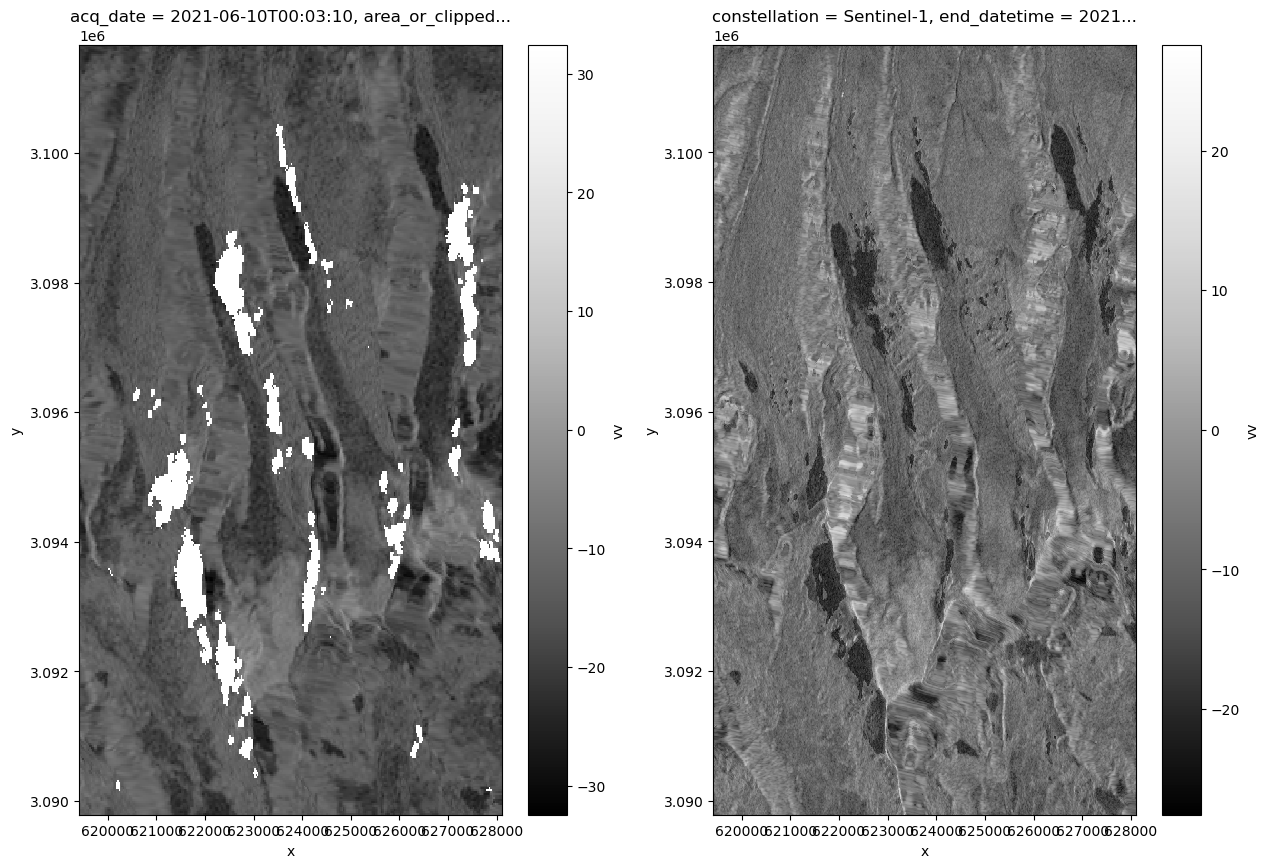

In [49]:
asf_pc_sidebyside(asf_subset, pc_subset, 10)

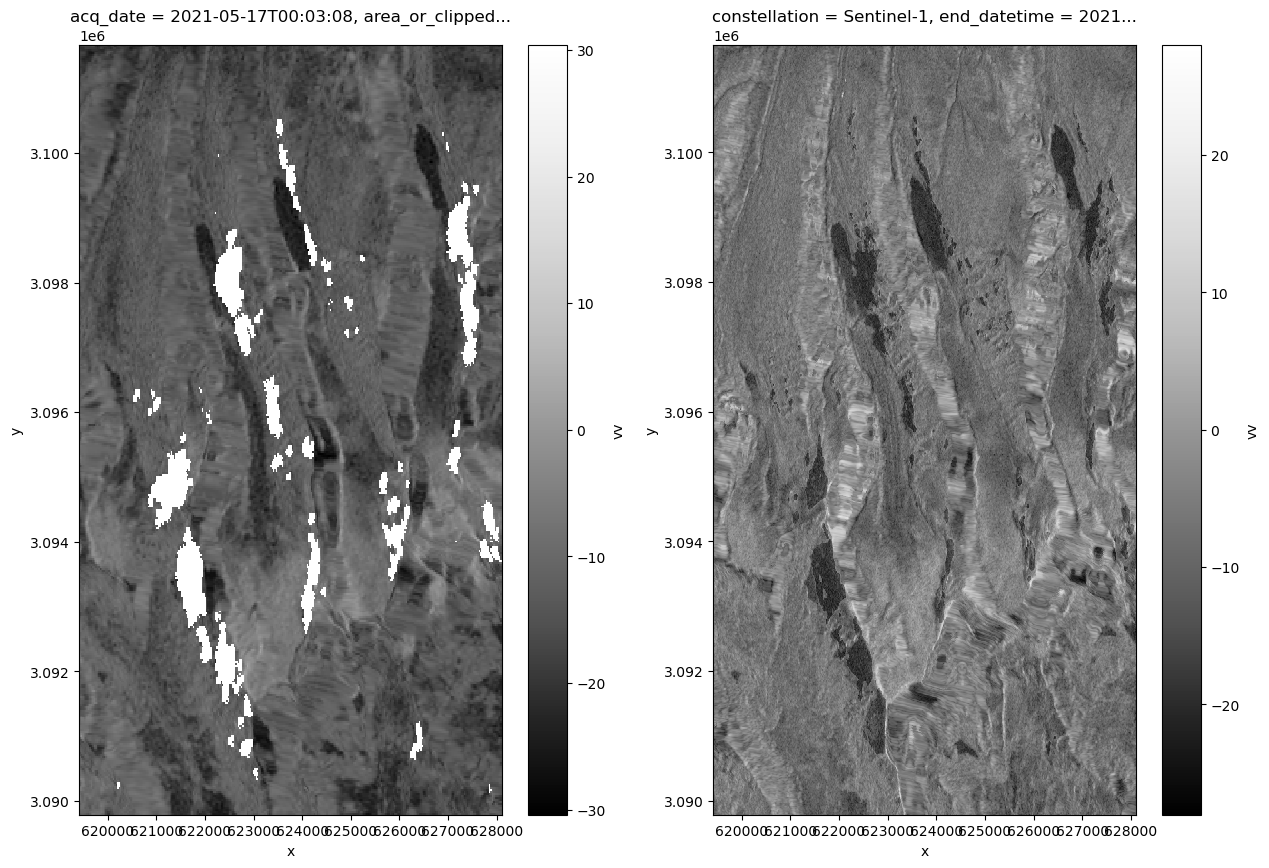

In [50]:
asf_pc_sidebyside(asf_subset, pc_subset, 4)

### Average backscatter over time

Now we will look at the backscatter mean along the time dimension

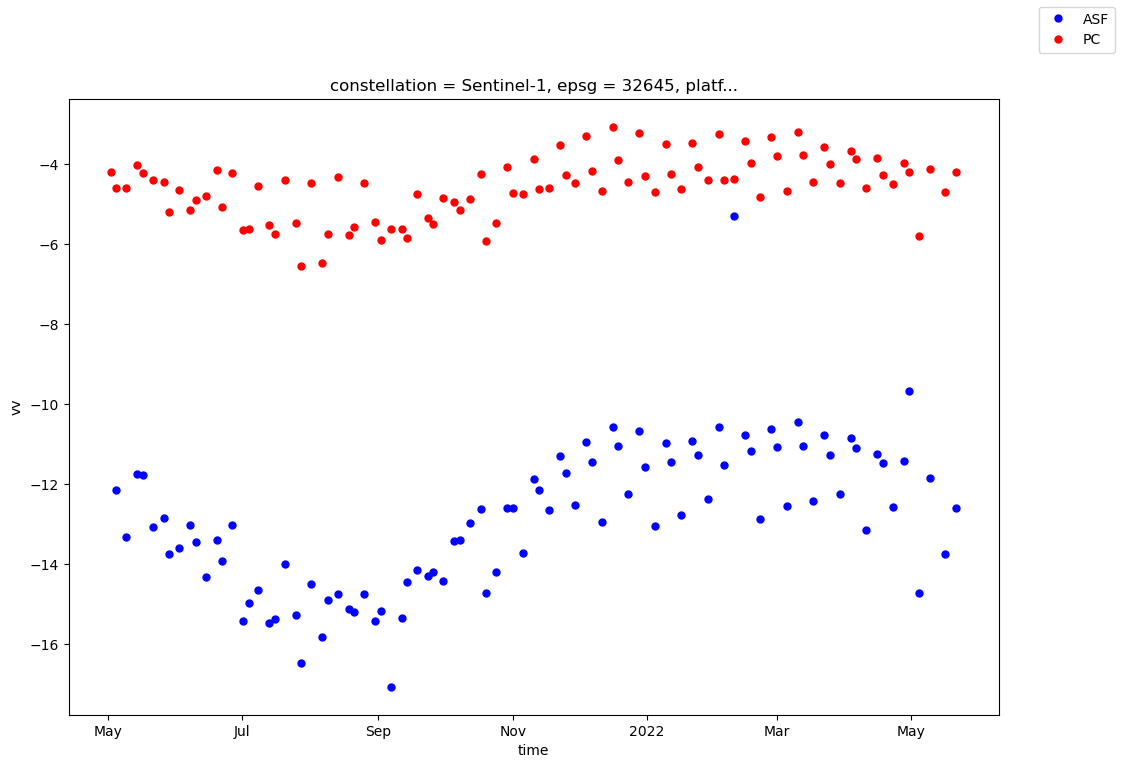

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))

power_to_db(asf_subset.vv.mean(dim=["x", "y"])).plot(
    ax=ax, color="blue", linestyle="None", marker="o", markersize=5, label="ASF"
)
power_to_db(pc_subset.vv.mean(dim=["x", "y"])).plot(
    ax=ax, color="red", linestyle="None", marker="o", markersize=5, label="PC"
)
fig.legend();

## Handling spatial resolution differences

The PC dataset has a higher spatial resolution than the ASF dataset, which you can see in the sizes of the x and y dimensions of the dataset. The ASF dataset masks out more pixels due to shadow than the PC dataset. To explore whether or not this is the cause of the observed backscatter offset between the two, we need to mask out the pixels in the PC dataset that are masked in the ASF dataset. 

In order to do this, first we must downsample the PC dataset to match the spatial resolution of the ASF dataset. There are multiple xarray methods that could be used but here we will use the `xr.interp_like()` method because we would like the PC x and y dimensions to match the ASF dimensiosn exactly. 

In [52]:
asf_subset = asf_subset.rename({"acq_date": "time"})

In [53]:
asf_subset.time

<xarray.DataArray 'time' (time: 96)> Size: 768B
array(['2021-05-02T12:14:14.000000000', '2021-05-05T00:03:07.000000000',
       '2021-05-09T12:05:42.000000000', '2021-05-14T12:13:49.000000000',
       '2021-05-17T00:03:08.000000000', '2021-05-21T12:05:43.000000000',
       '2021-05-26T12:13:50.000000000', '2021-05-29T00:03:09.000000000',
       '2021-06-02T12:05:43.000000000', '2021-06-07T12:13:51.000000000',
       '2021-06-10T00:03:10.000000000', '2021-06-14T12:05:44.000000000',
       '2021-06-19T12:13:52.000000000', '2021-06-22T00:03:10.000000000',
       '2021-06-26T12:05:45.000000000', '2021-07-01T12:13:52.000000000',
       '2021-07-04T00:03:11.000000000', '2021-07-08T12:05:45.000000000',
       '2021-07-13T12:13:53.000000000', '2021-07-16T00:03:12.000000000',
       '2021-07-20T12:05:46.000000000', '2021-07-25T12:13:54.000000000',
       '2021-07-28T00:03:12.000000000', '2021-08-01T12:05:47.000000000',
       '2021-08-06T12:13:54.000000000', '2021-08-09T00:03:13.000000000',
       '2021-08-13T12:05:48.000000000', '2021-08-18T12:13:55.000000000',
       '2021-08-21T00:03:14.000000000', '2021-08-25T12:05:48.000000000',
       '2021-08-30T12:13:56.000000000', '2021-09-02T00:03:14.000000000',
       '2021-09-06T12:05:49.000000000', '2021-09-11T12:13:56.000000000',
       '2021-09-14T00:03:15.000000000', '2021-09-18T12:05:49.000000000',
       '2021-09-23T12:13:57.000000000', '2021-09-26T00:03:15.000000000',
       '2021-09-30T12:05:50.000000000', '2021-10-05T12:13:57.000000000',
       '2021-10-08T00:03:15.000000000', '2021-10-12T12:05:50.000000000',
       '2021-10-17T12:13:57.000000000', '2021-10-20T00:03:16.000000000',
       '2021-10-24T12:05:50.000000000', '2021-10-29T12:13:57.000000000',
       '2021-11-01T00:03:15.000000000', '2021-11-05T12:05:49.000000000',
       '2021-11-10T12:13:57.000000000', '2021-11-13T00:03:15.000000000',
       '2021-11-17T12:05:49.000000000', '2021-11-22T12:13:56.000000000',
       '2021-11-25T00:03:15.000000000', '2021-11-29T12:05:49.000000000',
       '2021-12-04T12:13:56.000000000', '2021-12-07T00:03:14.000000000',
       '2021-12-11T12:05:48.000000000', '2021-12-16T12:13:55.000000000',
       '2021-12-19T00:03:14.000000000', '2021-12-23T12:05:48.000000000',
       '2021-12-28T12:13:55.000000000', '2021-12-31T00:03:13.000000000',
       '2022-01-04T12:05:47.000000000', '2022-01-09T12:13:54.000000000',
       '2022-01-12T00:03:13.000000000', '2022-01-16T12:05:47.000000000',
       '2022-01-21T12:13:54.000000000', '2022-01-24T00:03:12.000000000',
       '2022-01-28T12:05:46.000000000', '2022-02-02T12:13:53.000000000',
       '2022-02-05T00:03:12.000000000', '2022-02-09T12:05:46.000000000',
       '2022-02-14T12:13:53.000000000', '2022-02-17T00:03:11.000000000',
       '2022-02-21T12:05:46.000000000', '2022-02-26T12:13:53.000000000',
       '2022-03-01T00:03:11.000000000', '2022-03-05T12:05:45.000000000',
       '2022-03-10T12:13:53.000000000', '2022-03-13T00:03:11.000000000',
       '2022-03-17T12:05:45.000000000', '2022-03-22T12:13:53.000000000',
       '2022-03-25T00:03:12.000000000', '2022-03-29T12:05:46.000000000',
       '2022-04-03T12:13:53.000000000', '2022-04-06T00:03:12.000000000',
       '2022-04-10T12:05:46.000000000', '2022-04-15T12:13:53.000000000',
       '2022-04-18T00:03:12.000000000', '2022-04-22T12:05:47.000000000',
       '2022-04-27T12:13:54.000000000', '2022-04-30T00:03:13.000000000',
       '2022-05-04T12:05:47.000000000', '2022-05-09T12:13:55.000000000',
       '2022-05-16T12:05:48.000000000', '2022-05-21T12:13:56.000000000'],
      dtype='datetime64[ns]')
Coordinates: (12/20)
  * time                              (time) datetime64[ns] 768B 2021-05-02T1...
    area_or_clipped                   (time) <U1 384B 'e' 'e' 'e' ... 'e' 'e'
    beam_mode                         (time) <U2 768B 'IW' 'IW' ... 'IW' 'IW'
    data_take_id                      (time) <U6 2kB '047321' ... '052C00'
    deadreckoning_or_demmatch         (time) <U1 384B 'd' 'd' 'd' ... 'd' 'd'
    gr

In [54]:
pc_downsample = pc_subset.interp_like(asf_subset)

In [55]:
pc_downsample

<xarray.Dataset> Size: 176MB
Dimensions:                                (time: 96, y: 396, x: 290)
Coordinates: (12/36)
    constellation                          <U10 40B 'Sentinel-1'
    epsg                                   int64 8B 32645
    platform                               <U11 44B 'SENTINEL-1A'
    proj:code                              <U10 40B 'EPSG:32645'
    s1:processing_level                    <U1 4B '1'
    s1:product_timeliness                  <U8 32B 'Fast-24h'
    ...                                     ...
    s1:orbit_source                        (time) <U8 3kB dask.array<chunksize=(18,), meta=np.ndarray>
    s1:slice_number                        (time) <U2 768B dask.array<chunksize=(18,), meta=np.ndarray>
    s1:total_slices                        (time) <U2 768B dask.array<chunksize=(18,), meta=np.ndarray>
    sat:orbit_state                        (time) <U10 4kB dask.array<chunksize=(18,), meta=np.ndarray>
    start_datetime                         (time) <U32 12kB dask.array<chunksize=(18,), meta=np.ndarray>
    data_take_id                           (time) <U6 2kB dask.array<chunksize=(18,), meta=np.ndarray>
Data variables:
    vh                                     (time, y, x) float64 88MB dask.array<chunksize=(96, 396, 290), meta=np.ndarray>
    vv                                     (time, y, x) float64 88MB dask.array<chunksize=(96, 396, 290), meta=np.ndarray>
Attributes:
    crs:            epsg:32645
    resolution_xy:  [9.788706070864338, 7.699930607059487]
    spec_dict:      {'bounds': [619419.5314582244, 3089781.9544171887, 628111...
    transform:      [9.788706070864338, 0.0, 619419.5314582244, 0.0, -7.69993...

In [56]:
pc_mask = xr.where(asf_subset[["vh", "vv"]].notnull(), pc_downsample, np.nan)

In [57]:
pc_mask

<xarray.Dataset> Size: 176MB
Dimensions:                                (time: 96, y: 396, x: 290)
Coordinates: (12/52)
  * time                                   (time) datetime64[ns] 768B 2021-05...
    area_or_clipped                        (time) <U1 384B 'e' 'e' ... 'e' 'e'
    beam_mode                              (time) <U2 768B 'IW' 'IW' ... 'IW'
    data_take_id                           (time) <U6 2kB '047321' ... '052C00'
    deadreckoning_or_demmatch              (time) <U1 384B 'd' 'd' ... 'd' 'd'
    notfiltered_or_filtered                (time) <U1 384B 'n' 'n' ... 'n' 'n'
    ...                                     ...
    s1:instrument_configuration_ID         (time) <U1 384B dask.array<chunksize=(18,), meta=np.ndarray>
    s1:orbit_source                        (time) <U8 3kB dask.array<chunksize=(18,), meta=np.ndarray>
    s1:slice_number                        (time) <U2 768B dask.array<chunksize=(18,), meta=np.ndarray>
    s1:total_slices                        (time) <U2 768B dask.array<chunksize=(18,), meta=np.ndarray>
    sat:orbit_state                        (time) <U10 4kB dask.array<chunksize=(18,), meta=np.ndarray>
    start_datetime                         (time) <U32 12kB dask.array<chunksize=(18,), meta=np.ndarray>
Data variables:
    vh                                     (time, y, x) float64 88MB dask.array<chunksize=(96, 396, 290), meta=np.ndarray>
    vv                                     (time, y, x) float64 88MB dask.array<chunksize=(96, 396, 290), meta=np.ndarray>

Oops, this isn't what we want. Now we have a 5-dimensional object instead of a 4-dimensional object, because the dimensions of the `asf_subset` object were broadcast onto the `pc_downsample` object, meaning that we have both a `time` and a `acq_date` object.

Let's go back and try to fix this...

In [58]:
pc_downsample.isel(time=0).time.values

numpy.datetime64('2021-05-02T12:14:14.000000000')

In [59]:
asf_subset.isel(time=0).time.values

numpy.datetime64('2021-05-02T12:14:14.000000000')

Okay, so we need to take the time off of the `pc_downsample` time coordinates:

In [60]:
pc_downsample.coords["time"] = pc_downsample.time.dt.date

In [61]:
pc_downsample.coords.dtypes

Frozen({'constellation': dtype('<U10'), 'epsg': dtype('int64'), 'platform': dtype('<U11'), 'proj:code': dtype('<U10'), 's1:processing_level': dtype('<U1'), 's1:product_timeliness': dtype('<U8'), 's1:resolution': dtype('<U4'), 'sar:center_frequency': dtype('float64'), 'sar:frequency_band': dtype('<U1'), 'sar:instrument_mode': dtype('<U2'), 'sar:looks_azimuth': dtype('int64'), 'sar:looks_equivalent_number': dtype('float64'), 'sar:looks_range': dtype('int64'), 'sar:observation_direction': dtype('<U5'), 'sar:pixel_spacing_azimuth': dtype('int64'), 'sar:pixel_spacing_range': dtype('int64'), 'sar:product_type': dtype('<U3'), 'sar:resolution_azimuth': dtype('int64'), 'sar:resolution_range': dtype('int64'), 'sat:absolute_orbit': dtype('float64'), 'sat:platform_international_designator': dtype('<U9'), 'sat:relative_orbit': dtype('float64'), 'x': dtype('float64'), 'y': dtype('float64'), 'end_datetime': dtype('<U32'), 'granule_id': dtype('<U62'), 'id': dtype('<U66'), 's1:datatake_id': dtype('<U6'

In [68]:
pc_subset.time

<xarray.DataArray 'time' (time: 96)> Size: 768B
array(['2021-05-02T12:14:02.953073000', '2021-05-05T00:03:21.746142000',
       '2021-05-09T12:05:56.202200000', '2021-05-14T12:14:03.650190000',
       '2021-05-17T00:03:22.364326000', '2021-05-21T12:05:56.706900000',
       '2021-05-26T12:14:04.351880000', '2021-05-29T00:03:23.152330000',
       '2021-06-02T12:05:57.441074000', '2021-06-07T12:14:05.058343000',
       '2021-06-10T00:03:23.870450000', '2021-06-14T12:05:58.373830000',
       '2021-06-19T12:14:05.865662000', '2021-06-22T00:03:24.594621000',
       '2021-06-26T12:05:58.982444000', '2021-07-01T12:14:06.572473000',
       '2021-07-04T00:03:25.347747000', '2021-07-08T12:05:59.613554000',
       '2021-07-13T12:14:07.266919000', '2021-07-16T00:03:26.093195000',
       '2021-07-20T12:06:00.428473000', '2021-07-25T12:14:07.814919000',
       '2021-07-28T00:03:26.667023000', '2021-08-01T12:06:01.150857000',
       '2021-08-06T12:14:08.698596000', '2021-08-09T00:03:27.454588000',
       '2021-08-13T12:06:01.713793000', '2021-08-18T12:14:09.226637000',
       '2021-08-21T00:03:28.059716000', '2021-08-25T12:06:02.421490000',
       '2021-08-30T12:14:09.783019000', '2021-09-02T00:03:28.464707000',
       '2021-09-06T12:06:02.971474000', '2021-09-11T12:14:10.406593000',
       '2021-09-14T00:03:29.135941000', '2021-09-18T12:06:03.415938000',
       '2021-09-23T12:14:10.788780000', '2021-09-26T00:03:29.558327000',
       '2021-09-30T12:06:03.760613000', '2021-10-05T12:14:11.035095000',
       '2021-10-08T00:03:29.713275000', '2021-10-12T12:06:03.850150000',
       '2021-10-17T12:14:11.200359000', '2021-10-20T00:03:29.919736000',
       '2021-10-24T12:06:03.954256000', '2021-10-29T12:14:11.052769000',
       '2021-11-01T00:03:29.702246000', '2021-11-05T12:06:03.645002000',
       '2021-11-10T12:14:10.742983000', '2021-11-13T00:03:29.481869000',
       '2021-11-17T12:06:03.560526000', '2021-11-22T12:14:10.576899000',
       '2021-11-25T00:03:29.120003000', '2021-11-29T12:06:03.035677000',
       '2021-12-04T12:14:10.007158000', '2021-12-07T00:03:28.568419000',
       '2021-12-11T12:06:02.513966000', '2021-12-16T12:14:09.596874000',
       '2021-12-19T00:03:28.141449000', '2021-12-23T12:06:01.793721000',
       '2021-12-28T12:14:08.858303000', '2021-12-31T00:03:27.432317000',
       '2022-01-04T12:06:01.280484000', '2022-01-09T12:14:08.415805000',
       '2022-01-12T00:03:27.070182000', '2022-01-16T12:06:00.877035000',
       '2022-01-21T12:14:07.716165000', '2022-01-24T00:03:26.424832000',
       '2022-01-28T12:06:00.352862000', '2022-02-02T12:14:07.057390000',
       '2022-02-05T00:03:25.849186000', '2022-02-09T12:06:00.019287000',
       '2022-02-14T12:14:07.178103000', '2022-02-17T00:03:25.677942000',
       '2022-02-21T12:05:59.939806000', '2022-02-26T12:14:07.075742000',
       '2022-03-01T00:03:25.589986000', '2022-03-05T12:05:59.677073000',
       '2022-03-10T12:14:06.994606000', '2022-03-13T00:03:25.744897000',
       '2022-03-17T12:05:59.706124000', '2022-03-22T12:14:07.362180000',
       '2022-03-25T00:03:26.139523000', '2022-03-29T12:06:00.140262000',
       '2022-04-03T12:14:07.585924000', '2022-04-06T00:03:26.181999000',
       '2022-04-10T12:06:00.398442000', '2022-04-15T12:14:07.711367000',
       '2022-04-18T00:03:26.603587000', '2022-04-22T12:06:01.051309000',
       '2022-04-27T12:14:08.426000000', '2022-04-30T00:03:27.201903000',
       '2022-05-04T12:06:01.122366000', '2022-05-09T12:14:08.980398000',
       '2022-05-16T12:06:02.314833000', '2022-05-21T12:14:09.786375000'],
      dtype='datetime64[ns]')
Coordinates: (12/34)
    constellation                          <U10 40B ...
    end_datetime                           (time) <U32 12kB dask.array<chunksize=(18,), meta=np.ndarray>
    epsg                                   int64 8B ...
    granule_id                             (time) <U62 24kB dask.array<chunksize=(18,), meta=np.ndarray>
    id                                     (time) <U66 25kB dask.array<chu

In [69]:
asf_subset.time

<xarray.DataArray 'time' (time: 96)> Size: 768B
array(['2021-05-02T12:14:14.000000000', '2021-05-05T00:03:07.000000000',
       '2021-05-09T12:05:42.000000000', '2021-05-14T12:13:49.000000000',
       '2021-05-17T00:03:08.000000000', '2021-05-21T12:05:43.000000000',
       '2021-05-26T12:13:50.000000000', '2021-05-29T00:03:09.000000000',
       '2021-06-02T12:05:43.000000000', '2021-06-07T12:13:51.000000000',
       '2021-06-10T00:03:10.000000000', '2021-06-14T12:05:44.000000000',
       '2021-06-19T12:13:52.000000000', '2021-06-22T00:03:10.000000000',
       '2021-06-26T12:05:45.000000000', '2021-07-01T12:13:52.000000000',
       '2021-07-04T00:03:11.000000000', '2021-07-08T12:05:45.000000000',
       '2021-07-13T12:13:53.000000000', '2021-07-16T00:03:12.000000000',
       '2021-07-20T12:05:46.000000000', '2021-07-25T12:13:54.000000000',
       '2021-07-28T00:03:12.000000000', '2021-08-01T12:05:47.000000000',
       '2021-08-06T12:13:54.000000000', '2021-08-09T00:03:13.000000000',
       '2021-08-13T12:05:48.000000000', '2021-08-18T12:13:55.000000000',
       '2021-08-21T00:03:14.000000000', '2021-08-25T12:05:48.000000000',
       '2021-08-30T12:13:56.000000000', '2021-09-02T00:03:14.000000000',
       '2021-09-06T12:05:49.000000000', '2021-09-11T12:13:56.000000000',
       '2021-09-14T00:03:15.000000000', '2021-09-18T12:05:49.000000000',
       '2021-09-23T12:13:57.000000000', '2021-09-26T00:03:15.000000000',
       '2021-09-30T12:05:50.000000000', '2021-10-05T12:13:57.000000000',
       '2021-10-08T00:03:15.000000000', '2021-10-12T12:05:50.000000000',
       '2021-10-17T12:13:57.000000000', '2021-10-20T00:03:16.000000000',
       '2021-10-24T12:05:50.000000000', '2021-10-29T12:13:57.000000000',
       '2021-11-01T00:03:15.000000000', '2021-11-05T12:05:49.000000000',
       '2021-11-10T12:13:57.000000000', '2021-11-13T00:03:15.000000000',
       '2021-11-17T12:05:49.000000000', '2021-11-22T12:13:56.000000000',
       '2021-11-25T00:03:15.000000000', '2021-11-29T12:05:49.000000000',
       '2021-12-04T12:13:56.000000000', '2021-12-07T00:03:14.000000000',
       '2021-12-11T12:05:48.000000000', '2021-12-16T12:13:55.000000000',
       '2021-12-19T00:03:14.000000000', '2021-12-23T12:05:48.000000000',
       '2021-12-28T12:13:55.000000000', '2021-12-31T00:03:13.000000000',
       '2022-01-04T12:05:47.000000000', '2022-01-09T12:13:54.000000000',
       '2022-01-12T00:03:13.000000000', '2022-01-16T12:05:47.000000000',
       '2022-01-21T12:13:54.000000000', '2022-01-24T00:03:12.000000000',
       '2022-01-28T12:05:46.000000000', '2022-02-02T12:13:53.000000000',
       '2022-02-05T00:03:12.000000000', '2022-02-09T12:05:46.000000000',
       '2022-02-14T12:13:53.000000000', '2022-02-17T00:03:11.000000000',
       '2022-02-21T12:05:46.000000000', '2022-02-26T12:13:53.000000000',
       '2022-03-01T00:03:11.000000000', '2022-03-05T12:05:45.000000000',
       '2022-03-10T12:13:53.000000000', '2022-03-13T00:03:11.000000000',
       '2022-03-17T12:05:45.000000000', '2022-03-22T12:13:53.000000000',
       '2022-03-25T00:03:12.000000000', '2022-03-29T12:05:46.000000000',
       '2022-04-03T12:13:53.000000000', '2022-04-06T00:03:12.000000000',
       '2022-04-10T12:05:46.000000000', '2022-04-15T12:13:53.000000000',
       '2022-04-18T00:03:12.000000000', '2022-04-22T12:05:47.000000000',
       '2022-04-27T12:13:54.000000000', '2022-04-30T00:03:13.000000000',
       '2022-05-04T12:05:47.000000000', '2022-05-09T12:13:55.000000000',
       '2022-05-16T12:05:48.000000000', '2022-05-21T12:13:56.000000000'],
      dtype='datetime64[ns]')
Coordinates: (12/20)
  * time                              (time) datetime64[ns] 768B 2021-05-02T1...
    area_or_clipped                   (time) <U1 384B 'e' 'e' 'e' ... 'e' 'e'
    beam_mode                         (time) <U2 768B 'IW' 'IW' ... 'IW' 'IW'
    data_take_id                      (time) <U6 2kB '047321' ... '052C00'
    deadreckoning_or_demmatch         (time) <U1 384B 'd' 'd' 'd' ... 'd' 'd'
    gr

In [70]:
xr.__version__

'2024.10.0'

## TODO
This didn't throw an error before but does now (xarray: `'2024.10.0'`), fix later


In [62]:
asf_subset.coords.dtypes

Frozen({'time': dtype('<M8[ns]'), 'area_or_clipped': dtype('<U1'), 'beam_mode': dtype('<U2'), 'data_take_id': dtype('<U6'), 'deadreckoning_or_demmatch': dtype('<U1'), 'granule_id': dtype('<U67'), 'notfiltered_or_filtered': dtype('<U1'), 'orbit_type': dtype('<U1'), 'orbital_dir': dtype('<U4'), 'output_type': dtype('<U1'), 'output_unit': dtype('<U1'), 'polarization_type': dtype('<U1'), 'primary_polarization': dtype('<U1'), 'processing_software': dtype('<U1'), 'prod_type': dtype('<U2'), 'product_id': dtype('<U4'), 'sensor': dtype('<U3'), 'spatial_ref': dtype('int64'), 'terrain_correction_pixel_spacing': dtype('<U5'), 'unmasked_or_watermasked': dtype('<U1'), 'x': dtype('float64'), 'y': dtype('float64')})

Now let's try again:

In [63]:
pc_mask = xr.where(asf_subset.notnull(), pc_downsample, np.nan)

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',)

In [ ]:
pc_mask

,Array,Chunk
Bytes,145.44 MiB,897.19 kiB
Shape,"(83, 396, 290, 2)","(1, 396, 290, 1)"
Count,42 Graph Layers,166 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,145.44 MiB,897.19 kiB
Shape,"(83, 396, 290, 2)","(1, 396, 290, 1)"
Count,53 Graph Layers,166 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


Great! Looks like its working

In [ ]:
asf_subset

<xarray.Dataset>
Dimensions:                           (time: 83, y: 396, x: 290)
Coordinates: (12/20)
  * time                              (time) datetime64[ns] 2021-06-02 ... 20...
    granule_id                        (time) <U67 'S1A_IW_SLC__1SDV_20210602T...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (time) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
    filtered                          (time) <U1 'n' 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (time) <U1 'e' 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (time) <U4 '1424' 'ABA0' ... '5BAD' 'BD36'
    acq_hour                          (time) int64 12 12 0 12 0 ... 12 0 0 0 0
    orbital_dir                       (time) <U4 'desc' 'desc' ... 'asc' 'asc'
    data_take_id                      (time) <U6 '0480FD' '048318' ... '052C00'
Data variables:
    vv                                (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (time, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (time, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [45]:
pc_mask

<xarray.Dataset> Size: 176MB
Dimensions:                                (time: 96, y: 396, x: 290)
Coordinates: (12/52)
    product_id                             (time) object 768B '3C39' ... 'F7ED'
    output_unit                            (time) object 768B 'p' 'p' ... 'p'
    orbit_type                             (time) object 768B 'P' 'P' ... 'P'
  * y                                      (y) float64 3kB 3.102e+06 ... 3.09...
  * x                                      (x) float64 2kB 6.194e+05 ... 6.28...
    spatial_ref                            int64 8B 0
    ...                                     ...
    s1:instrument_configuration_ID         (time) object 768B dask.array<chunksize=(18,), meta=np.ndarray>
    s1:datatake_id                         (time) object 768B dask.array<chunksize=(18,), meta=np.ndarray>
    id                                     (time) object 768B dask.array<chunksize=(18,), meta=np.ndarray>
    s1:slice_number                        (time) object 768B dask.array<chunksize=(18,), meta=np.ndarray>
    start_datetime                         (time) object 768B dask.array<chunksize=(18,), meta=np.ndarray>
    s1:orbit_source                        (time) object 768B dask.array<chunksize=(18,), meta=np.ndarray>
Data variables:
    vh                                     (time, y, x) float64 88MB dask.array<chunksize=(96, 396, 290), meta=np.ndarray>
    vv                                     (time, y, x) float64 88MB dask.array<chunksize=(96, 396, 290), meta=np.ndarray>

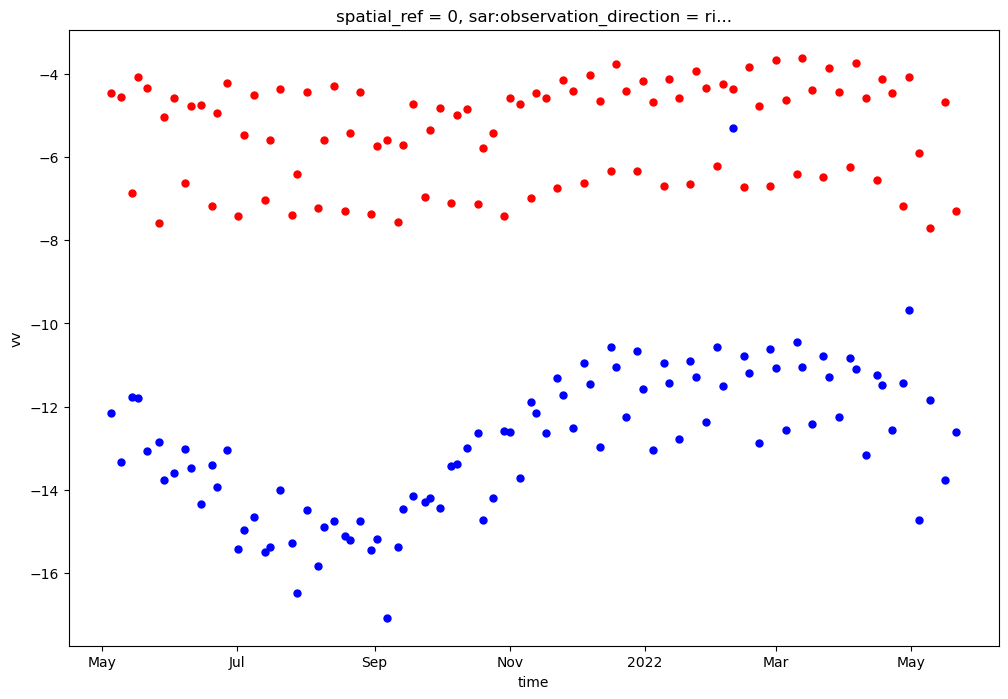

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))

power_to_db(asf_subset.vv.mean(dim=["x", "y"])).plot(
    ax=ax, color="blue", linestyle="None", marker="o", markersize=5, label="ASF"
)
power_to_db(pc_mask["vv"].mean(dim=["x", "y"], skipna=True)).plot(
    x="time", ax=ax, color="red", linestyle="None", marker="o", markersize=5, label="PC"
);

## Break up by asc, desc pass


Use `xr.where()` to subset datasets by orbital pass:

In [ ]:
asf_subset

<xarray.Dataset>
Dimensions:                           (acq_date: 90, y: 396, x: 290)
Coordinates: (12/20)
  * acq_date                          (acq_date) datetime64[ns] 2021-06-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '1424' 'ABA0' ... 'BD36'
    acq_hour                          (acq_date) int64 12 12 0 12 ... 0 12 12 0
    orbital_dir                       (acq_date) <U4 'desc' 'desc' ... 'asc'
    data_take_id                      (acq_date) <U6 '0480FD' ... '052C00'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [47]:
asf_desc = asf_subset.where(asf_subset["orbital_dir"] == "desc", drop=True)
asf_asc = asf_subset.where(asf_subset["orbital_dir"] == "asc", drop=True)

In [ ]:
# asf_asc.vv.mean(dim=['x','y']).plot(marker='o', linestyle='None')

In [51]:
pc_subset = pc_subset.compute()

In [52]:
pc_desc = pc_subset.where(pc_subset["sat:orbit_state"] == "descending", drop=True)
pc_asc = pc_subset.where(pc_subset["sat:orbit_state"] == "ascending", drop=True)

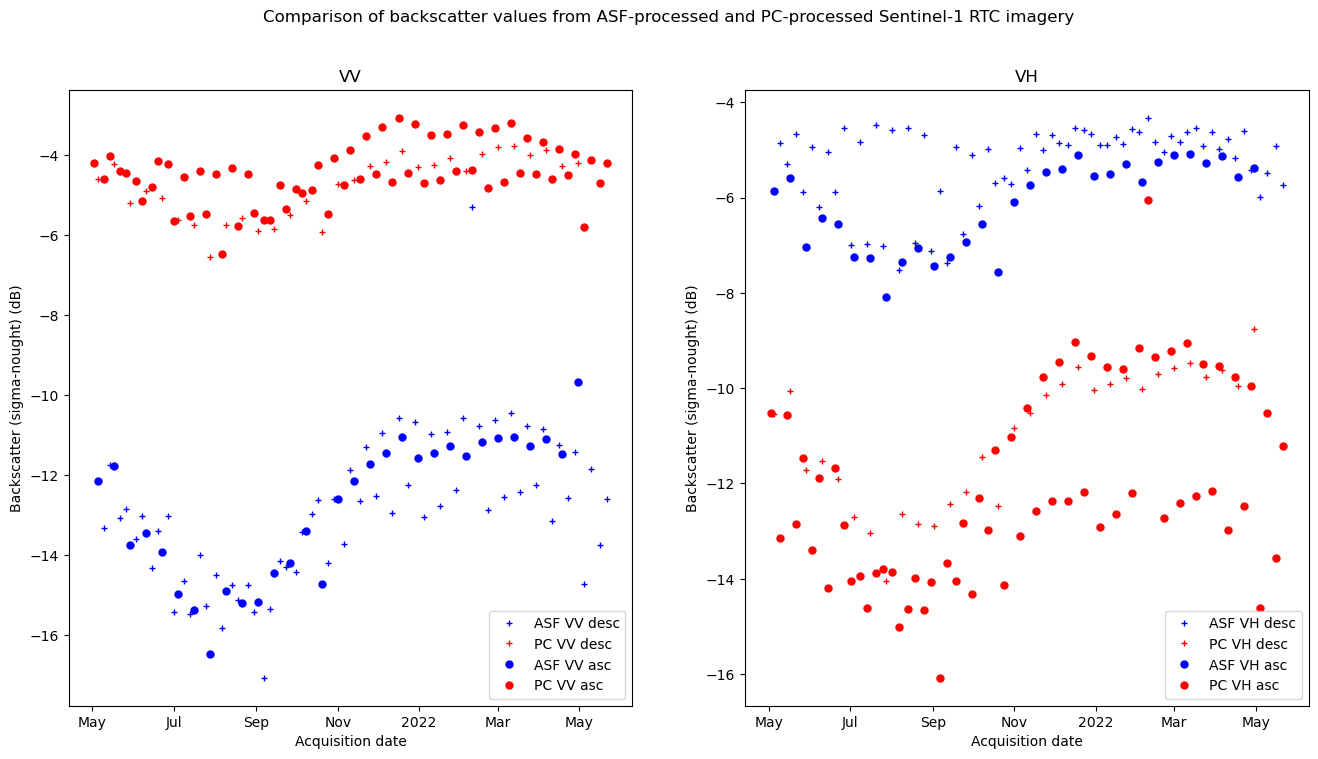

In [53]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 8))

power_to_db(asf_desc.vv.mean(dim=["x", "y"])).plot(
    ax=axs[0],
    color="blue",
    linestyle="None",
    marker="+",
    markersize=5,
    label="ASF VV desc",
)
power_to_db(pc_desc.vv.mean(dim=["x", "y"])).plot(
    ax=axs[0],
    color="red",
    linestyle="None",
    marker="+",
    markersize=5,
    label="PC VV desc",
)
power_to_db(asf_asc.vv.mean(dim=["x", "y"])).plot(
    ax=axs[0],
    color="blue",
    linestyle="None",
    marker="o",
    markersize=5,
    label="ASF VV asc",
)
power_to_db(pc_asc.vv.mean(dim=["x", "y"])).plot(
    ax=axs[0],
    color="red",
    linestyle="None",
    marker="o",
    markersize=5,
    label="PC VV asc",
)
axs[0].legend(loc="lower right")
axs[0].set_xlabel("Acquisition date")
axs[0].set_ylabel("Backscatter (sigma-nought) (dB)")
axs[0].set_title("VV")

power_to_db(asf_desc.vh.mean(dim=["x", "y"])).plot(
    ax=axs[1],
    color="blue",
    linestyle="None",
    marker="+",
    markersize=5,
    label="ASF VH desc",
)
power_to_db(pc_desc.vh.mean(dim=["x", "y"])).plot(
    ax=axs[1],
    color="red",
    linestyle="None",
    marker="+",
    markersize=5,
    label="PC VH desc",
)
power_to_db(asf_asc.vh.mean(dim=["x", "y"])).plot(
    ax=axs[1],
    color="blue",
    linestyle="None",
    marker="o",
    markersize=5,
    label="ASF VH asc",
)
power_to_db(pc_asc.vh.mean(dim=["x", "y"])).plot(
    ax=axs[1],
    color="red",
    linestyle="None",
    marker="o",
    markersize=5,
    label="PC VH asc",
)
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Acquisition date")
axs[1].set_ylabel("Backscatter (sigma-nought) (dB)")
axs[1].set_title("VH")

fig.suptitle(
    "Comparison of backscatter values from ASF-processed and PC-processed Sentinel-1 RTC imagery"
);